In [0]:
!pip install -U git+https://github.com/python-visualization/folium

In [0]:
!pip install requests

In [0]:
!pip install -U networkx

In [0]:
import json
import operator
import requests

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from google.cloud import bigquery
from google.colab import auth, files

In [0]:
auth.authenticate_user()
PROJECT_ID = 'bugseeker'
client = bigquery.Client(project=PROJECT_ID)

In [0]:
def plot_choropleth(_df, _col_name, _leg_name):
  """ Plot a choropleth map using a pandas dataframe and folium. """
  cc_json_raw = requests.get('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/countries.geo.lim.json').text  
  cc_json = json.loads(cc_json_raw)
  m = folium.Map(
    location=[4., -8],
    tiles='Mapbox Bright',
    zoom_start=2
  )

  folium.Choropleth(
      geo_data=cc_json,
      name='choropleth',
      data=_df,
      columns=['country2', _col_name],
      key_on='feature.id',
      fill_color='YlOrRd',
      fill_opacity=0.7,
      line_opacity=0.2,
      legend_name=_leg_name
  ).add_to(m)

  return m

In [0]:
def draw_country_graph(_df, _year, _country2):
  """ Plot an undirected graph where _country2 is at the center and all the countries
      that are associated with humanitarian aid events are plotted around _country2.
      The size of the nodes represents the number of mentions about humanitarian aid
      for a given year.
  """
  # grab a subgraph of the data for the specified year
  i = (df_graph['year'] == pd.to_datetime('{}-01-01'.format(_year))) & \
      ((df_graph['actor1'] == _country2) | (df_graph['actor2'] == _country2))
  
  df_subgraph = df_graph[i]
  u_countries = np.union1d(df_subgraph['actor1'].unique(),
                           df_subgraph['actor2'].unique())
    
  # build a networkx graph from the data
  g = nx.Graph()
  
  for c in u_countries:
    g.add_node(c, name=c)
  node_sizes = dict()
  base_size = 800
  max_size = 2500
  min_num_mentions = df_subgraph['num_mentions'].min()
  max_num_mentions = df_subgraph['num_mentions'].max()  
  for row_idx,row in df_subgraph.iterrows():
    other_country = row['actor1'] if row['actor2'] == _country2 else row['actor2']
    sz = (row['num_mentions'] - min_num_mentions) / (max_num_mentions - min_num_mentions)
    node_sizes[other_country] = base_size + sz*(max_size - base_size)
    g.add_edge(row['actor1'], row['actor2'], weight=row['num_mentions'])
   
  node_sizes[_country2] = base_size

  # plot the graph
  node_size_arr = [node_sizes[c] for c in u_countries]  
  fig,ax = plt.subplots(figsize=(12, 12))
  nx.draw_spring(g, node_color='#81BEF7', alpha=0.75, with_labels=True, node_size=node_size_arr) 
  

# Global Humanitarian Aid Networks

The [GDELT Project](https://www.gdeltproject.org/data.html) offers an unprecedented view of world events as portrayed by the global media. The GDELT event database contains billions of machine annotated events processed from internet articles, updated every 15 minutes, and hosted on Google BigQuery. The purpose of this notebook is to aggregate information about humanitarian aid to countries and provide tools to visualize and understand the data.


## Introduction: Humanitarian Aid in a Nutshell

Not being an expert on aid, or a trained social scientist, or an economist, one can consult [wikipedia](https://en.wikipedia.org/wiki/Humanitarian_aid) and [the sources it cites](http://euhap.eu/upload/2014/09/the-state-of-art-of-humanitarian-action-2013.pdf) to gain a basic understanding about what humanitarian aid is and is not.

First and foremost, humanitarian aid seeks to provide **emergency response** to people in need, with the goal of saving lives and reducing human suffering, while preserving human dignity. Emergencies can be **man-made** or **natural**. Aid workers are trained to act in a manner that is **non-discriminatory** and **neutral** to sides involved in a conflict and governmental entities.

Modern humanitarian aid is administered by international agencies such as the **Red Cross** and the **United Nations**, and a plethora of other [non-governmental organizations (NGOs)](http://guides.lib.berkeley.edu/c.php?g=496970&p=3626027). These organizations provide medical assistance to wounded civilians in **war zones**, peace-keeping in **post-conflict areas**, distribute food to fight **world hunger**, provide services to **refugees**, and relief to those afflicted by **natural disaster**.

The effectiveness of foreign aid, that given from one government to another, can be **controversial**. When aid is ascribed  the goal of increasing a country's economic growth, the results are complex and debated, as described in [this article](https://www.weforum.org/agenda/2014/11/how-effective-is-foreign-aid/). In regards to food aid, it can sometimes be diverted to the wrong people, with negative consequences. For example, food aid to Somalia has been observed to be diverted to a [web of corrupt people and agencies](https://www.nytimes.com/2010/03/10/world/africa/10somalia.html). Foreign aid may be linked to the onset or exacerbation of violent conflict in receiving countries, as speculated in [this paper](http://www.michael-findley.com/uploads/2/0/4/5/20455799/worlddev_2011_gis-aid1.pdf). Optimizing the way in which humanitarian aid is distributed to those in need is an important problem that society faces.



## Interactive View for Global Data

You can use the interactive map widget below to view population, humanitarian aid, poverty rate, and fraction of violent events mentioned for each country. The base 10 logarithm is applied to each of the quantities for visualization purposes. The map widget can be compared with [this visualization](http://data.devinit.org/global-picture/humanitarian-finance) as a reference.

In [0]:
# load the per country/year dataset and apply transformations to columns
df =  pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/pop_pov_aid_vio_norm.csv',
                  keep_default_na=False, na_values=['nan'])
df['year'] = pd.to_datetime(df['year'], format='%Y-%m-%d')
df['poverty_rate'] = df['poverty'] / df['population']
df['aid_per_capita'] = df['human_aid'] / df['population']
df['log_population'] = np.log10(df['population'])
df['log_violence'] = np.log10(df['violent_num_mentions_frac'] + 1e-8)
df['log_poverty'] = np.log10(df['poverty_rate'] + 1e-5)
df['aid_per_capita'][df['aid_per_capita'] < 0] = 0
df['log_aid'] = np.log10(df['aid_per_capita'] + 1e-8)

In [31]:
#@markdown Choose a quantity to view:
col_to_show = 'log_violence' #@param ['log_population', 'log_aid', 'log_poverty', 'log_violence']

#@markdown Choose a year to visualize data:
year_to_show = 2016 #@param {type:"slider", min:2000, max:2016, step:1}

col_label = '{} in {}'.format(col_to_show, year_to_show)

#@markdown Run this cell after changing the selection to view the map. Greyed-out countries don't have data.

i = df.year == pd.to_datetime('{}-01-01'.format(year_to_show))
plot_choropleth(df[i], col_to_show, col_label)

## Relationships between Violence, Poverty, and Aid

The following scatterplots illustrate the pairwise relationship between violence, poverty, and aid, with a different color for each country. All 16 years of data are plotted for each country within the same color:

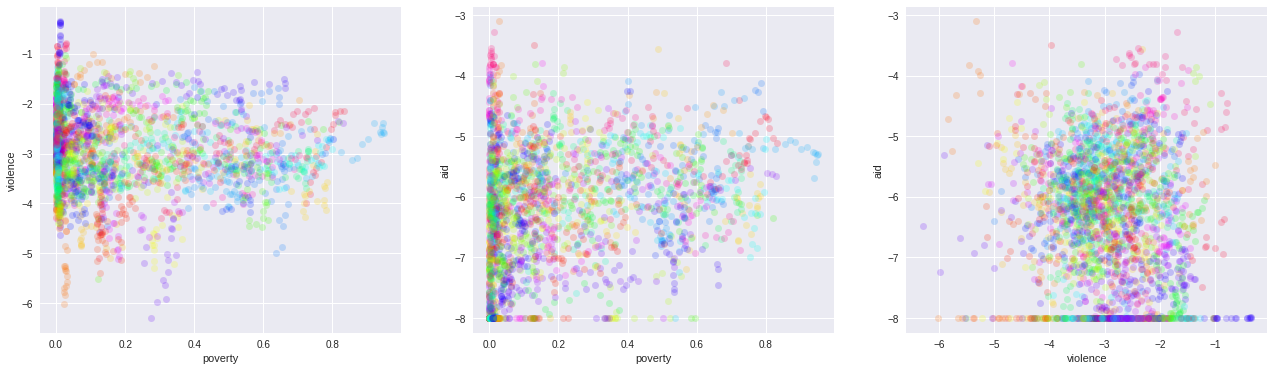

In [30]:
g = df.groupby(['country2'])
cmap = plt.cm.get_cmap('hsv', len(g))
color_idx = np.arange(len(g))
np.random.seed(12345)
np.random.shuffle(color_idx)

alpha = 0.2

fig = plt.figure(figsize=(22, 6))

ax = plt.subplot(1, 3, 1)
for k,(c2,gdf) in enumerate(g):
  plt.plot(gdf['poverty_rate'], gdf['log_violence'], 'o', c=cmap(color_idx[k]), alpha=alpha)
plt.xlabel('poverty')
plt.ylabel('violence')

ax = plt.subplot(1, 3, 2)
for k,(c2,gdf) in enumerate(g):
  plt.plot(gdf['poverty_rate'], gdf['log_aid'], 'o', c=cmap(color_idx[k]), alpha=alpha)
plt.xlabel('poverty')
plt.ylabel('aid')

ax = plt.subplot(1, 3, 3)
for k,(c2,gdf) in enumerate(g):
  plt.plot(gdf['log_violence'], gdf['log_aid'], 'o', c=cmap(color_idx[k]), alpha=alpha)
plt.xlabel('violence')
plt.ylabel('aid');




## Visualizing Aid Networks

The GDELT events dataset is rich enough to represent two actors that are interacting in the event. We can use this to determine when two countries are exchanging humanitarian aid, and build an undirected graph from that data. The graph can give us insights as to where humanitarian aid originates from, and in conjunction with the country-level dataset above, can illustrate where humanitarian aid goes. 

In [0]:
df_graph = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/gdelt_human_aid_graph.csv',
                       keep_default_na=False, na_values=['nan'])
df_graph['year'] = pd.to_datetime(df_graph['year'], format='%Y-%m-%d')

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


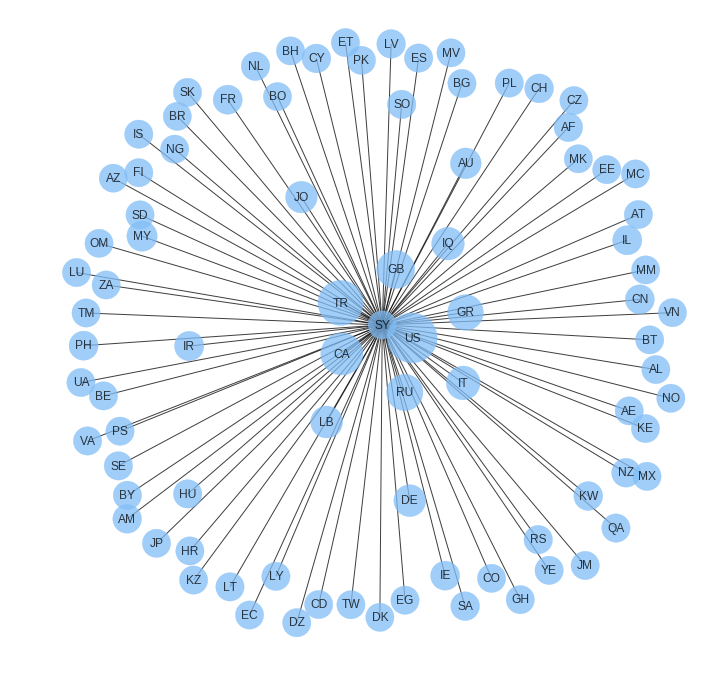

In [0]:
year_to_show = 2016 #@param {type:"slider", min:2000, max:2016, step:1}

country_to_show = 'SY' #@param ['SY', 'AF', 'SU', 'YE', 'TR']

draw_country_graph(df_graph, year_to_show, country_to_show)

# Data Sources

1. GDELT Event Dataset: http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf
2. Development Data Hub Humanitarian Finance: http://data.devinit.org/global-picture/humanitarian-finance
3. Development Data Hub Poverty: http://data.devinit.org/global-picture/poverty
3. ISO-ALPHA 3156 Two- and Three-letter Country Codes: https://gis.stackexchange.com/questions/1047/full-list-of-iso-alpha-2-and-iso-alpha-3-country-codes
4. World Bank Population Data by Country: https://data.worldbank.org/indicator/SP.POP.TOTL
5. World Countries GeoJSON: https://github.com/johan/world.geo.json


# Methods


## Exploring the GDELT Events Dataset

In this section, the GDELT database is explored in aggregate, without regard for event type, to provide some rationale for the choices made in the final analysis.

### Number of Events over Time

The GDELT project has aggregated global event information from 1979 to present day. The number of events recorded has increased exponentially over time, and logarithmically increases roughly in proportion to the world population, as the following plot shows:

In [0]:
# load world population file
df_world_population = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/world_population.csv')
df_world_population['Year'] = pd.to_datetime(df_world_population['Year'].astype('str'), format='%Y')
df_world_population.set_index('Year', inplace=True)
df_world_population['PopulationBillions'] = df_world_population['Population'] / 1e9

In [0]:
df_aid_yearly = client.query('''
SELECT
Year AS year,
Actor1CountryCode AS actor1_country_code,
Actor2CountryCode AS actor2_country_code,
COUNT(EventRootCode) AS event_count,
SUM(NumMentions) AS num_mentions

FROM `gdelt-bq.full.events`

WHERE
MonthYear >= 200001 AND MonthYear <= 201812
AND ActionGeo_Type = 1
AND EventBaseCode = '073'
AND Actor1CountryCode <> Actor2CountryCode
AND Actor1CountryCode IS NOT NULL
AND Actor2CountryCode IS NOT NULL

GROUP BY Year,EventBaseCode,Actor1CountryCode,Actor2CountryCode

ORDER BY Year,EventBaseCode
''').to_dataframe()
df_aid_yearly['year'] = pd.to_datetime(df_aid_yearly['year'].astype('int').astype('str'), format='%Y')


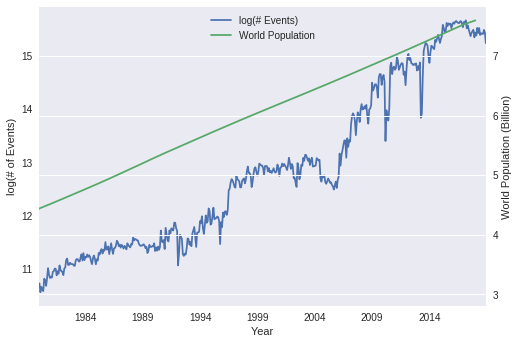

In [0]:
plt.figure()
ax = plt.subplot(111)
# ax_right = ax.twinx()
df_agg_events['log_event_count'] = np.log(df_agg_events['event_count'].values)
df_agg_events['log_event_count'].plot(ax=ax, label="log(# Events)")
plt.ylabel('log(# of Events)')
df_world_population['PopulationBillions'].plot(ax=ax, secondary_y=True, label='World Population')
plt.ylabel('World Population (Billion)')
plt.xlabel('Year')
ax.set_xlim(pd.Timestamp('1980-01-01'), pd.Timestamp('2018-12-30'))
lines = ax.get_lines() + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

### Event Importance over Time

GDELT offers a few different fields for judging event importance:

* NumArticles: the total number of source documents containing one or more mentions of this event during the 15 minute update in which it was first seen
* NumSources: the total number of information sources containing one or more mentions of this event during the 15 minute update in which it was first seen
* NumMentions:  the total number of mentions of this event across all source documents during the 15 minute update in which it was first seen.  Multiple references to an event within a single document also contribute to this count.

It was observed that the number of mentions and articles are closely matched, and the average number of sources per article is low. There is an acceleration in the number of articles per year that begins around 2006. The following query and plot demonstrates this:

In [0]:
df_importance_per_month = client.query('''
SELECT
MonthYear AS month_year,
SUM(NumMentions) / COUNT(EventCode) AS avg_num_mentions,
SUM(NumArticles) / COUNT(EventCode) AS avg_num_articles,
SUM(NumSources) / COUNT(EventCode) AS avg_num_sources
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 198001 AND MonthYear <= 201812
GROUP BY MonthYear
ORDER BY MonthYear
''').to_dataframe()

df_importance_per_month = df_importance_per_month.dropna()
df_importance_per_month['month_year'] = \
   pd.to_datetime(df_importance_per_month['month_year'].astype('str'), format='%Y%m')
df_importance_per_month.set_index('month_year', inplace=True)

Text(0.5, 0, 'Year')

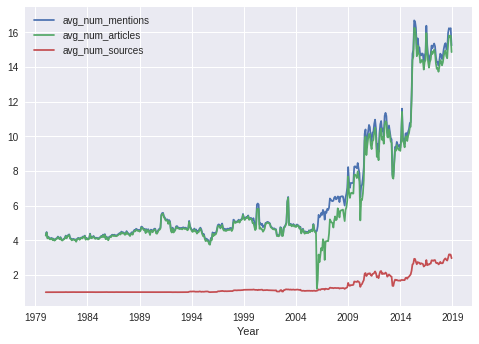

In [0]:
df_importance_per_month.plot()
plt.xlabel('Year')

### Distribution of Location Specifiers

The field ```ActionGeo_Type``` takes on one of the following values:
* 1: COUNTRY
* 2: USSTATE
* 3: USCITY
* 4: WORLDCITY
* 5: WORLDSTATE

Looking at the distribution of location specifiers over time, it seems like many of the events are at the city level globally, and there are also many events at the country level. Individual US states are well represented, but that is not true globally:

In [0]:
df_loc_spec_per_month = client.query('''
SELECT
MonthYear AS month_year,
ActionGeo_Type AS action_geo_type,
COUNT(ActionGeo_Type) AS action_geo_type_count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 198001 AND MonthYear <= 201812 AND ActionGeo_Type IN (1, 2, 3, 4, 5)
GROUP BY MonthYear,ActionGeo_Type
ORDER BY MonthYear
''').to_dataframe()

df_loc_spec_per_month['month_year'] = \
   pd.to_datetime(df_loc_spec_per_month['month_year'].astype('str'), format='%Y%m')
df_loc_spec_per_month.set_index('month_year', inplace=True)

action_type_names = ['Country', 'US State', 'US City', 'World City', 'World State']
df_loc_spec_per_month['action_geo_type_cat'] = df_loc_spec_per_month['action_geo_type'].map(lambda x: action_type_names[x-1]).astype('category')

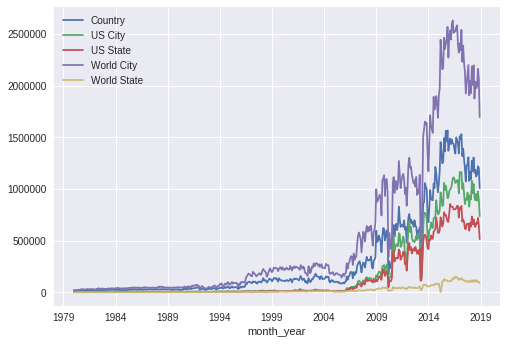

In [0]:
fig,ax = plt.subplots()
for key,grp in df_loc_spec_per_month.groupby('action_geo_type_cat'):
  grp['action_geo_type_count'].plot(label=key)
plt.legend()

### Impact and Tone

The GDELT database contains two numerical fields that try to quantify the impact and the sentiment (tone) of an event:

* Goldstein Scale: a numeric score from -10 to +10, capturing the theoretical potential impact that type of event will have on the stability of a country
* AvgTone: average “tone” of all documents containing one or more mentions of this event during the 15 minute update in which it was first seen.  The score ranges from -100 (extremely negative) to +100 (extremely positive).

There is also a hierarchy of codes that describe the nature of an event. The highest level code is the field "QuadClass", which is breaks an event down into four categories:

* 1: Verbal Cooperation
* 2: Material Cooperation
* 3: Verbal Conflict
* 4: Material Conflict

Obviously the impact and tone of an event will be heavily influenced by it's type, so the plot of impact and tone over time should be broken down by these categories. When examining the plot, the Goldstein scale seems relatively constant by QuadClass, as does the tone. The tone exhibits some weirdness around 2012:

In [0]:
df_impact_tone_per_month = client.query('''
SELECT
MonthYear AS month_year,
QuadClass AS quad_class,
AVG(GoldsteinScale) AS avg_goldstein_scale,
AVG(AvgTone) AS avg_tone
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 198001 AND MonthYear <= 201812 AND ActionGeo_Type IN (1, 2, 3, 4, 5)
GROUP BY MonthYear,QuadClass
ORDER BY MonthYear
''').to_dataframe()

df_impact_tone_per_month['month_year'] = \
   pd.to_datetime(df_impact_tone_per_month['month_year'].astype('str'), format='%Y%m')
df_impact_tone_per_month.set_index('month_year', inplace=True)

quad_class_names = ['Verbal Cooperation', 'Material Cooperation', 'Verbal Conflict', 'Material Conflict']
df_impact_tone_per_month['quad_class_cat'] = df_impact_tone_per_month['quad_class'].map(lambda x: quad_class_names[x-1]).astype('category')

Text(0, 0.5, 'Avg Tone')

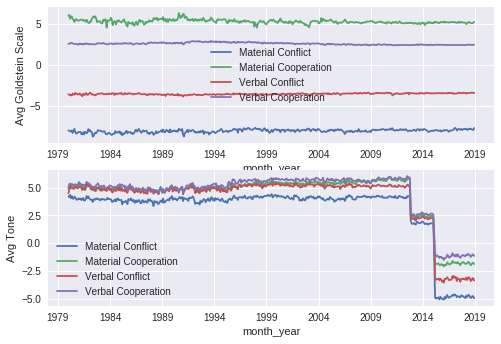

In [0]:
fig = plt.figure()

ax = plt.subplot(2, 1, 1)
for key,grp in df_impact_tone_per_month.groupby('quad_class_cat'):
  grp['avg_goldstein_scale'].plot(label=key)
plt.legend()
plt.ylabel('Avg Goldstein Scale')

ax = plt.subplot(2, 1, 2)
for key,grp in df_impact_tone_per_month.groupby('quad_class_cat'):
  grp['avg_tone'].plot(label=key)
plt.legend()
plt.ylabel('Avg Tone')


### Event Codes

Each event is coded in a hierarchical way. The "EventRootCode" field is broken down into the following values:

* 01: MAKE PUBLIC STATEMENT
* 02: APPEAL
* 03: EXPRESS INTENT TO COOPERATE
* 04: CONSULT
* 05: ENGAGE IN DIPLOMATIC COOPERATION
* 06: ENGAGE IN MATERIAL COOPERATION
* 07: PROVIDE AID
* 08: YIELD
* 09: INVESTIGATE
* 10: DEMAND
* 11: DISAPPROVE
* 12: REJECT
* 13: THREATEN
* 14: PROTEST
* 15: EXHIBIT FORCE POSTURE
* 16: REDUCE RELATIONS
* 17: COERCE
* 18: ASSAULT
* 19: FIGHT
* 20: USE UNCONVENTIONAL MASS VIOLENCE


In [0]:
df_event_root_code_per_month = client.query('''
SELECT
MonthYear AS month_year,
EventRootCode as event_root_code,
COUNT(EventRootCode) AS event_root_code_count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 198001 AND MonthYear <= 201812 AND
ActionGeo_Type IN (1, 2, 3, 4, 5)
AND EventRootCode IS NOT NULL
AND EventRootCode <> 'X'
AND EventRootCode <> '--'
GROUP BY MonthYear,EventRootCode
ORDER BY MonthYear,EventRootCode
''').to_dataframe()

In [0]:
df_event_root_code_per_month['month_year'] = \
   pd.to_datetime(df_event_root_code_per_month['month_year'].astype('str'), format='%Y%m')
df_event_root_code_per_month.set_index('month_year', inplace=True)

event_root_code_names = {
    '01': 'MAKE PUBLIC STATEMENT',
    '02': 'APPEAL',
    '03': 'EXPRESS INTENT TO COOPERATE',
    '04': 'CONSULT',
    '05': 'ENGAGE IN DIPLOMATIC COOPERATION',
    '06': 'ENGAGE IN MATERIAL COOPERATION',
    '07': 'PROVIDE AID',
    '08': 'YIELD',
    '09': 'INVESTIGATE',
    '10': 'DEMAND',
    '11': 'DISAPPROVE',
    '12': 'REJECT',
    '13': 'THREATEN',
    '14': 'PROTEST',
    '15': 'EXHIBIT FORCE POSTURE',
    '16': 'REDUCE RELATIONS',
    '17': 'COERCE',
    '18': 'ASSAULT',
    '19': 'FIGHT',
    '20': 'USE UNCONVENTIONAL MASS VIOLENCE'
}

df_event_root_code_per_month['event_root_code_cat'] = df_event_root_code_per_month['event_root_code'].map(lambda x: event_root_code_names[x]).astype('category')

In [0]:
unique_idx = df_event_root_code_per_month.index.unique()
years = [(k,x.year) for k,x in enumerate(unique_idx) if x.month == 1 and x.year % 5 == 0]
print(years)

[(0, 1980), (60, 1985), (120, 1990), (180, 1995), (240, 2000), (300, 2005), (360, 2010), (420, 2015)]


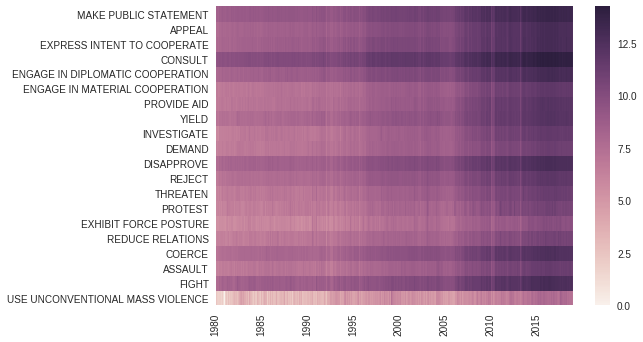

In [0]:
# build a matrix to make a heatmap with
sorted_code_names = [x[1] for x in sorted(event_root_code_names.items(), key=operator.itemgetter(0))]
unique_idx = df_event_root_code_per_month.index.unique()
event_code_time_matrix = np.zeros([len(sorted_code_names), len(unique_idx)])
for k,code_name in enumerate(sorted_code_names):
  i = df_event_root_code_per_month.event_root_code_cat == code_name
  idx = [np.where(unique_idx == d)[0][0] for d in df_event_root_code_per_month.index[i]]
  event_code_time_matrix[k, idx] = df_event_root_code_per_month.event_root_code_count[i].values

event_code_time_matrix = np.log(event_code_time_matrix + 1) 
xtks_years = [(k,x.year) for k,x in enumerate(unique_idx) if x.month == 1 and x.year % 5 == 0]
ytks = reversed(sorted_code_names)
  
fig,ax = plt.subplots()
sns.heatmap(event_code_time_matrix, ax=ax)
plt.xticks([x[0] for x in xtks_years])
ax.set_xticklabels([x[1] for x in xtks_years]);
ax.set_yticklabels(ytks, rotation=0);


## Construction of Final Datasets

For the analysis in this notebook, two main datasets were synthesized from a variety of sources:

1. **Aid Network Dataset**: bilateral humanitarian aid events from GDELT aggregated by year.
2. **Country Properties by Year Dataset**: data on countries by year, which includes population, poverty, humanitarian financial aid accepted, and number of violent events from GDELT, aggregated by year.



### Violent Events Dataset

An aggregation of violent events within a country for each year was constructed from the GDELT database as well. The query utilized the ActionGeo_CountryCode field and event root codes 17-20, which are events that involve coercion, assault, fighting, and unconvential mass violence.

In [0]:
df_violence = client.query('''
SELECT
Year AS year,
ActionGeo_CountryCode AS action_country_code,
COUNT(EventRootCode) AS event_count,
SUM(NumMentions) AS total_num_mentions

FROM `gdelt-bq.full.events`

WHERE MonthYear >= 200001 AND MonthYear <= 201812
AND ActionGeo_Type IN (1, 2, 3, 4, 5)
AND EventRootCode IN ('17', '18', '19', '20')

GROUP BY Year,ActionGeo_CountryCode

ORDER BY Year,ActionGeo_CountryCode
''').to_dataframe()
df_violence['year'] = pd.to_datetime(df_violence['year'].astype('int').astype('str'), format='%Y')

In [0]:
df_violence.to_csv('gdelt_violence.csv', index=False)
files.download('gdelt_violence.csv')

### Violence, Poverty, Aid, and Population by Country and Year Dataset

The dataset was supplemented with non-GDELT data, by merging several datasets into one:

1. Development Data Hub Humanitarian Finance: http://data.devinit.org/global-picture/humanitarian-finance
2. Development Data Hub Poverty: http://data.devinit.org/global-picture/poverty
3. Development Data Hub Government Revenue: http://data.devinit.org/global-picture/government-finance
4. ISO-ALPHA 3156 Two- and Three-letter Country Codes: https://gis.stackexchange.com/questions/1047/full-list-of-iso-alpha-2-and-iso-alpha-3-country-codes
5. World Bank Population Data by Country: https://data.worldbank.org/indicator/SP.POP.TOTL

The following code accomplishes this synthesis:

In [0]:
df_countries = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/country_codes.csv',
						               keep_default_na=False, na_values=['nan', 'null', 'NaN', 'NULL'])
c2_c3 = {row['Country2']:row['Country3'] for row_idx,row in df_countries.iterrows()}
c3_c2 = {row['Country3']:row['Country2'] for row_idx,row in df_countries.iterrows()}
cname_c2 = {row['Country']:row['Country2'] for row_idx,row in df_countries.iterrows()}
c2_cname = {row['Country2']:row['Country'] for row_idx,row in df_countries.iterrows()}
fips_c2 = {row['fips']:row['Country2'] for row_idx,row in df_countries.iterrows()}

# load the humanitarian finance dataset
df_human_finance = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/ddh_humanitarian_assistance.csv',
								               keep_default_na=False, na_values=['nan', 'null', 'NaN', 'NULL'])
df_human_finance['year'] = pd.to_datetime(df_human_finance['year'].astype('str'), format='%Y')
i = (df_human_finance['year'] >= pd.to_datetime('2000-01-01')) & (df_human_finance['year'] <= pd.to_datetime('2018-12-31'))
df_human_finance = df_human_finance[i]
df_human_finance['country2'] = df_human_finance['country2'].astype('category')
df_human_finance.set_index(['country2', 'year'], inplace=True)
del df_human_finance['country_name']

# load the poverty dataset
df_poverty = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/ddh_poverty.csv',
						             keep_default_na=False, na_values=['nan', 'null', 'NaN', 'NULL'])
df_poverty['year'] = pd.to_datetime(df_poverty['year'].astype('str'), format='%Y')
i = (df_poverty['year'] >= pd.to_datetime('2000-01-01')) & (df_poverty['year'] <= pd.to_datetime('2018-12-31'))
df_poverty = df_poverty[i]
df_poverty['country2'] = df_poverty['country2'].astype('category')
df_poverty.set_index(['country2', 'year'], inplace=True)
del df_poverty['country_name']

# load the world population by country and year dataset
df_worldpop = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/world_population_by_country_flat_with2018.csv',
            						  keep_default_na=False, na_values=['nan', 'null', 'NaN', 'NULL'])
df_worldpop['year'] = pd.to_datetime(df_worldpop['year'].astype('str'), format='%Y')
df_worldpop['country2'] = df_worldpop['country3'].map(lambda x: c3_c2.get(x, 'MISSING'))
i = df_worldpop['country2'] != 'MISSING'
df_worldpop =  df_worldpop[i]
i = (df_worldpop['year'] >= pd.to_datetime('2000-01-01')) & (df_worldpop['year'] <= pd.to_datetime('2018-12-31'))
df_worldpop = df_worldpop[i]
df_worldpop['country2'] = df_worldpop['country2'].astype('category')
df_worldpop.set_index(['country2', 'year'], inplace=True)
del df_worldpop['country3']

# load the gdelt violence dataset
df_violence = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/gdelt_violence.csv',
						              keep_default_na=False, na_values=['nan', 'null', 'NaN', 'NULL'])	
df_violence.rename(columns={'event_count':'violent_event_count',
                            'total_num_mentions':'violent_num_mentions',
                            'action_country_code':'country2'}, inplace=True)
df_violence['year'] = pd.to_datetime(df_violence['year'].astype('str'), format='%Y-%m-%d')

i = [x in fips_c2 for x in df_violence['country2']]
df_violence = df_violence[i]
df_violence['country2'] = [fips_c2[x] for x in df_violence['country2']]
df_violence.set_index(['country2', 'year'], inplace=True)

# join all the datasets
df_pop_pov_aid_vio = pd.merge(df_worldpop, df_human_finance, left_index=True, right_index=True, how='outer')
df_pop_pov_aid_vio = pd.merge(df_pop_pov_aid_vio, df_poverty, left_index=True, right_index=True, how='outer')
df_pop_pov_aid_vio = pd.merge(df_pop_pov_aid_vio, df_violence, left_index=True, right_index=True, how='outer')

# exclude some countries that have been found to have missing population data
excluded_countries = ['AI', 'CK', 'EH', 'FK', 'GF', 'GP', 'MQ', 'MS', 'PM', 'RE', 'TK', 'TW', 'VA', 'YT', 'WF']
i = np.array([idx[0] in excluded_countries for idx in df_pop_pov_aid_vio.index])
df_pop_pov_aid_vio = df_pop_pov_aid_vio[~i]
df_pop_pov_aid_vio.sort_index(inplace=True)

# add a column for readable country name, remove rows with no corresponding country name
df_pop_pov_aid_vio['country_name'] = [c2_cname.get(idx[0], 'MISSING') for idx in df_pop_pov_aid_vio.index]
i = df_pop_pov_aid_vio['country_name'] == 'MISSING'
df_pop_pov_aid_vio = df_pop_pov_aid_vio[~i]

# fill in missing values for numeric columns with NaNs, convert to float. there shouldn't be any empty
# strings in the categorical or date columns
df = df.replace('', np.nan)
for col_name in ['population', 'human_aid', 'poverty', 'violent_event_count', 'violent_num_mentions']:
  df[col_name] = df[col_name].astype('float')

In [0]:
df_pop_pov_aid_vio.to_csv('pop_pov_aid_vio.csv', header=True, index=True, na_rep='nan')
files.download('pop_pov_aid_vio.csv')

### Dealing with Missing Data

Unfortunately there is missing poverty and aid data for a number of countries. Many of the countries missing data are small and won't impact analysis very much. Other countries, such as France, Saudia Arabia, Afghanistan, Somalia, and others are significant losses. Ultimately the decision was made to move forward on the single country analysis by dropping countries that are missing data. The following investigation details the losses and the changes in summary statisics that result:

In [0]:
df_pop_pov_aid_vio =  pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/pop_pov_aid_vio.csv',
                                  keep_default_na=False, na_values=['nan'])
df_pop_pov_aid_vio['year'] = pd.to_datetime(df_pop_pov_aid_vio['year'], format='%Y-%m-%d')
df_pop_pov_aid_vio['country2'] = df_pop_pov_aid_vio['country2'].astype('category')
df_pop_pov_aid_vio.describe()

,human_aid,poverty,violent_event_count,violent_num_mentions
count,3298.000000,2.880000e+03,4.133000e+03,4.133000e+03
mean,49.629667,7.092711e+06,1.602891e+04,2.041636e+05
std,171.636954,3.477996e+07,1.138759e+05,1.868358e+06
min,-0.031549,0.000000e+00,1.000000e+00,2.000000e+00
25%,0.000000,2.455475e+04,2.960000e+02,1.772000e+03
50%,2.072716,2.824382e+05,1.636000e+03,1.005100e+04
75%,19.431356,3.375304e+06,6.751000e+03,5.407800e+04
max,2746.179305,4.749667e+08,3.233492e+06,6.030687e+07


In [0]:
# drop the rows with nans in them, check out the difference in summary statistics
df_pop_pov_aid_vio_limited = df_pop_pov_aid_vio.dropna()
df_pop_pov_aid_vio_limited.describe()

,human_aid,poverty,violent_event_count,violent_num_mentions
count,2549.000000,2.549000e+03,2.549000e+03,2.549000e+03
mean,57.166642,7.733976e+06,1.784459e+04,2.085170e+05
std,186.122759,3.668315e+07,1.189638e+05,1.821577e+06
min,-0.031549,0.000000e+00,1.000000e+00,2.000000e+00
25%,0.292682,3.806433e+04,5.880000e+02,3.330000e+03
50%,4.080108,3.966520e+05,2.156000e+03,1.352900e+04
75%,28.131685,3.986271e+06,7.588000e+03,5.955500e+04
max,2746.179305,4.749667e+08,3.233492e+06,6.030687e+07


In [0]:

# print out the countries that have been lost
countries_with_full_data = df_pop_pov_aid_vio_limited.country2.unique()
lost_countries = [c for c in df_pop_pov_aid_vio.country2.unique() if c not in countries_with_full_data]
print('Dropping NA rows lead to the loss of {} countries:'.format(len(df_pop_pov_aid_vio.country2.unique()) - len(df_pop_pov_aid_vio_limited.country2.unique())))
c2_name = {row['country2']:row['country_name'] for _,row in df_pop_pov_aid_vio.iterrows()}
lost_countries_names = [c2_name[c] for c in lost_countries if c in c2_name];
sorted(lost_countries_names)


Dropping NA rows lead to the loss of 73 countries:


['Afghanistan',
 'American Samoa',
 'Andorra',
 'Antarctica',
 'Antigua and Barbuda',
 'Argentina',
 'Aruba',
 'Bahamas',
 'Bahrain',
 'Barbados',
 'Bermuda',
 'Bouvet Island',
 'British Indian Ocean Territory',
 'British Virgin Islands',
 'Brunei',
 'Cambodia',
 'Cayman Islands',
 'Christmas Island',
 'Cuba',
 'Dominica',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Faroe Islands',
 'Finland',
 'France',
 'French Polynesia',
 'Gibraltar',
 'Greenland',
 'Grenada',
 'Guam',
 'Heard Island and McDonald Islands',
 'Hong Kong',
 'Iceland',
 'Ireland',
 'Isle of Man',
 'Kuwait',
 'Latvia',
 'Libya',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Macau',
 'Marshall Islands',
 'Monaco',
 'Namibia',
 'Nauru',
 'Netherlands',
 'New Caledonia',
 'New Zealand',
 'Niue',
 'Norfolk Island',
 'North Korea',
 'Northern Mariana Islands',
 'Norway',
 'Oman',
 'Palau',
 'Pitcairn',
 'Puerto Rico',
 'Qatar',
 'Saint Helena, Ascension and Tristan da Cunha',
 'Saint Kitts and Nevis',
 'Saint Martin',

### Normalizing GDELT Events Over Time

A significant observation of the GDELT dataset is that the number of reported violent events grows pretty nonlinearly over time. This is not because the world becomes exponentially more violent every year; it's due to improvements in technology and new sources of information being added to the GDELT database over time. After observing this effect, the choice was made to normalize the count of violent events and the number of mentions of violent events by the total sum across countries each year.



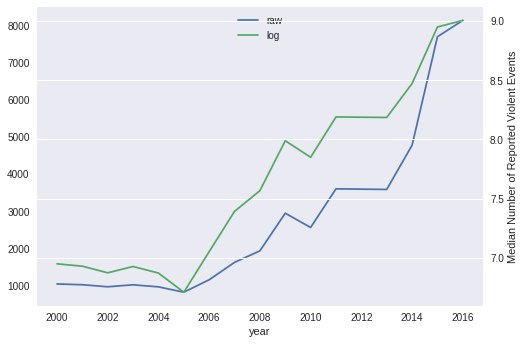

In [0]:
# group by year across countries and compute the median
df_yearly_mean = df_pop_pov_aid_vio_limited.groupby('year').aggregate(np.median)
df_yearly_mean['log_violent_event_count'] = np.log(df_yearly_mean['violent_event_count'])

# plot the average number of events over time
fig,ax = plt.subplots()
df_yearly_mean['violent_event_count'].plot(label='raw', ax=ax)
df_yearly_mean['log_violent_event_count'].plot(ax=ax, secondary_y=True, label='log')
plt.ylabel('Median Number of Reported Violent Events')
plt.xlabel('Year')
lines = ax.get_lines() + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

The following code accomplishes this normalization:

In [0]:
# sum violent mentions across years
df_yearly_sum = df_pop_pov_aid_vio_limited.groupby('year').aggregate(np.sum)

In [0]:
num_mentions_map = {row_idx:row['violent_num_mentions'] for row_idx,row in df_yearly_sum.iterrows()}
df_normed = df_pop_pov_aid_vio_limited.copy()
df_normed.set_index(['year', 'country2'], inplace=True)
df_normed['violent_num_mentions_frac'] = [
    row['violent_num_mentions'] / num_mentions_map[row_idx[0]] for row_idx,row in df_normed.iterrows()
]
# remove non-normalized columns
del df_normed['violent_num_mentions']
del df_normed['violent_event_count']

In [0]:
df_normed.to_csv('pop_pov_aid_vio_norm.csv', header=True, index=True, na_rep='nan')
files.download('pop_pov_aid_vio_norm.csv')

### Aid Network Dataset

This dataset was constructed for GDELT events with base code '073', which from the [CAMEO codebook](http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf), means that the actors involved 

In [0]:
df = client.query('''
SELECT
Year AS year,
Actor1CountryCode AS actor1_country_code,
Actor2CountryCode AS actor2_country_code,
COUNT(EventRootCode) AS event_count,
SUM(NumMentions) AS num_mentions

FROM `gdelt-bq.full.events`

WHERE
MonthYear >= 200001 AND MonthYear <= 201812
AND ActionGeo_Type = 1
AND EventBaseCode = '073'
AND Actor1CountryCode <> Actor2CountryCode
AND Actor1CountryCode IS NOT NULL
AND Actor2CountryCode IS NOT NULL

GROUP BY Year,EventBaseCode,Actor1CountryCode,Actor2CountryCode

ORDER BY Year,EventBaseCode
''').to_dataframe()
df['year'] = pd.to_datetime(df['year'].astype('int').astype('str'), format='%Y')

In [0]:
df.to_csv('gdelt_human_aid_yearly.csv', index=False)
files.download('gdelt_human_aid_yearly.csv')

After construction of the initial dataset, there was some refinement to exclude countries that could not be mapped to their constituent two-letter codes. Then an undirected graph was constructed for each year, where the node was a country, and each edge represented the total number of events or mentions between countries:

In [0]:
# load the countries dataset
df_countries = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/country_codes.csv',
						               keep_default_na=False, na_values=['nan'])
c2_c3 = {row['Country2']:row['Country3'] for row_idx,row in df_countries.iterrows()}
c3_c2 = {row['Country3']:row['Country2'] for row_idx,row in df_countries.iterrows()}
cname_c2 = {row['Country']:row['Country2'] for row_idx,row in df_countries.iterrows()}
c2_cname = {row['Country2']:row['Country'] for row_idx,row in df_countries.iterrows()}
fips_c2 = {row['fips']:row['Country2'] for row_idx,row in df_countries.iterrows()}

# load the unprocessed graph dataset
df = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/gdelt_human_aid_yearly.csv')
df['year'] = pd.to_datetime(df['year'], format='%Y-%m-%d')

# remove countries that don't have a two-letter code
u_countries = np.union1d(df['actor1_country_code'].unique(), df['actor2_country_code'].unique())
missing_countries = [x for x in u_countries if x not in c3_c2]
i = (df['actor1_country_code'].isin(missing_countries)) | (df['actor2_country_code'].isin(missing_countries))
df = df[~i]

# replace the three letter codes with two letter codes
df['actor1'] = df['actor1_country_code'].map(lambda x: c3_c2[x])
df['actor2'] = df['actor2_country_code'].map(lambda x: c3_c2[x])
del df['actor1_country_code']
del df['actor2_country_code']

# there is not necessarily any coherent directionality in the dataset, so an undirected
# graph can be built from it. group together the edges Country1-Country2 and Country2-Country1
# and sum up their values
df['edge_name'] = ['-'.join(sorted([row['actor1'], row['actor2']]))
						for row_idx,row in df.iterrows()]
df['edge_name'] = df['edge_name'].astype('category')
del df['actor1']
del df['actor2']

# now aggregate by year and edge, sum the events and mentions
df_graph = df.groupby(['year', 'edge_name']).aggregate(np.sum)
df_graph.reset_index(inplace=True)
nodes = [x.split('-') for x in df_graph['edge_name']]
df_graph['actor1'] = [x[0] for x in nodes]
df_graph['actor2'] = [x[1] for x in nodes]
del df_graph['edge_name']
i = np.isnan(df_graph['event_count']) | np.isnan(df_graph['num_mentions'])
df_graph = df_graph[~i]

# aggregate by year, to get the sum of event counts and mentions that can
# then be used as normalization factors
df_graph_yearly = df_graph.groupby('year').aggregate(np.sum)

# normalize the graph edges
for col in ['event_count', 'num_mentions']:
	df_graph[col] = [row[col] / df_graph_yearly.loc[row['year']][col] for row_idx,row in df_graph.iterrows()]
  
df_graph.sort_values(['year', 'actor1'], inplace=True)

In [0]:
df_graph.to_csv('gdelt_human_aid_graph.csv', index=False)
files.download('gdelt_human_aid_graph.csv')